In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                             user = "root",
                             password = "12345",
                             database = "ecommerce")
cur = db.cursor()


ProgrammingError: 1045 (28000): Access denied for user 'root'@'localhost' (using password: YES)

# 1. List all unique cities where customers are located.

In [4]:
query = """select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer_City"])
df

,Customer_City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# 2. Count the number of orders placed in 2017.

In [26]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()
"Total No. of orders placed in 2017 are: ", data[0][0]

('Total No. of orders placed in 2017 are: ', 45101)

# 3. Find the total sales per category.

In [34]:
query = """
select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products 
join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Product Category","Total Sales"])
df

,Product Category,Total Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# 4. Calculate the percentage of orders that were paid in installments.

In [37]:
query = """select sum(case when payment_installments >=1 then 1
else 0 end)/count(*)*100
from payments"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Percentage_Installments"])
df

,Percentage_Installments
0,99.9981


# 5. Count the number of customers from each state. 

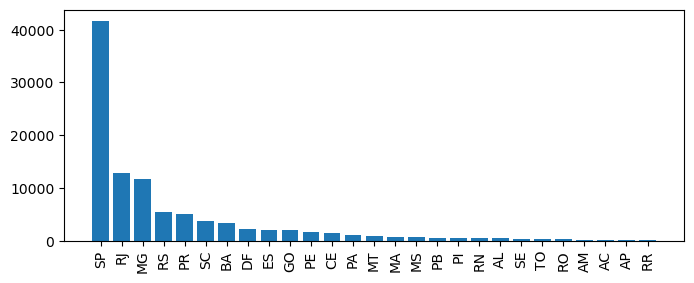

In [56]:
query = """select count(customer_id) Customers, customer_state
from customers
group by customer_state
"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customers","Customer_State"])
df = df.sort_values(by = "Customers", ascending = False)

plt.figure(figsize = (8,3))
plt.bar(df["Customer_State"], df["Customers"])
plt.xticks(rotation = 90)
plt.show()

# 6. Calculate the number of orders per month in 2018

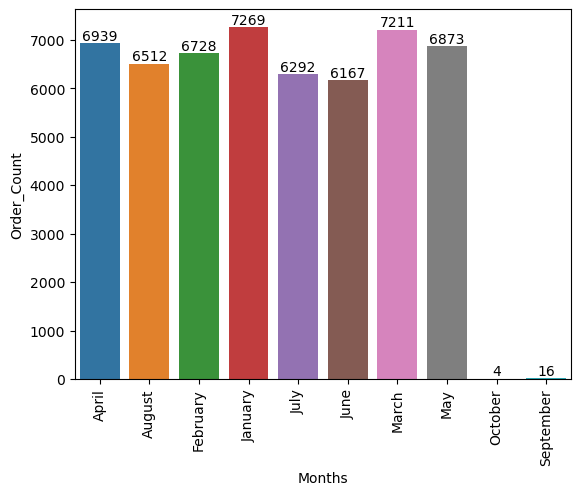

In [71]:
query = """select monthname(order_purchase_timestamp) months, count(order_id) order_count 
from orders where year(order_purchase_timestamp) = 2018
group by months"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Months","Order_Count"])
df = df.sort_values(by = "Months")


ax = sns.barplot(x = df["Months"], y = df["Order_Count"], data = df)
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 90)
plt.show()

# 7. Find the average number of products per order, grouped by customer city.

In [87]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) order_count
from orders 
join order_items
on orders.order_id = order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city, round(avg(count_per_order.order_count),2) average_orders from customers
join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
order by average_orders
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_city","average_orders"])
df = df.sort_values(by = "average_orders", ascending = False)
df.head(10)


,customer_city,average_orders
4109,padre carvalho,7.00
4108,celso ramos,6.50
4107,candido godoi,6.00
4106,datas,6.00
4105,matias olimpio,5.00
4102,curralinho,4.00
4100,morro de sao paulo,4.00
4101,teixeira soares,4.00
4103,cidelandia,4.00
4104,picarra,4.00


# 8. Calculate the percentage of total revenue contributed by each product category.

In [101]:
query = """
select upper(products.product_category) category, 
round((sum(payments.payment_value)/
(select sum(payment_value) from payments))*100,2) as sales_percentage
from products 
join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Product Category","Sales Percentage"])
df

,Product Category,Sales Percentage
0,PERFUMERY,3.17
1,FURNITURE DECORATION,8.93
2,TELEPHONY,3.04
3,BED TABLE BATH,10.70
4,AUTOMOTIVE,5.32
...,...,...
69,CDS MUSIC DVDS,0.01
70,LA CUISINE,0.02
71,FASHION CHILDREN'S CLOTHING,0.00
72,PC GAMER,0.01


# 9. Identify the correlation between product price and the number of times a product has been purchased.

In [115]:
import numpy as np
query = """select (products.product_category), count(order_items.product_id) as order_count,
round(avg(order_items.price),2) as price
from products join order_items
on products.product_id = order_items.product_id
group by products. product_category;
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Product Category","Order Count", "Avg. Price"])

arr1 = df["Order Count"]
arr2 = df["Avg. Price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157562


# 10. Calculate the total revenue generated by each seller, and rank them by revenue.

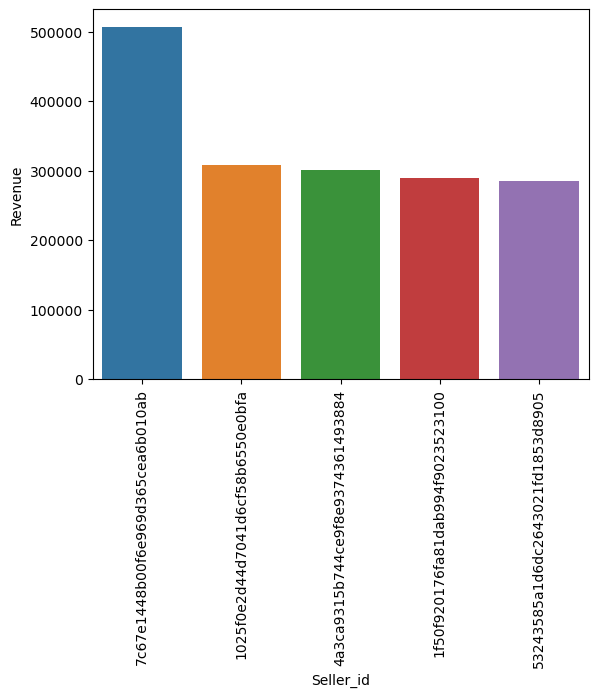

In [136]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value) as revenue 
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a;
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Seller_id", "Revenue", "Rank"])
df = df.head()
plt.xticks(rotation = 90)
sns.barplot(x = "Seller_id", y = "Revenue", data = df)
plt.show()

# 11. Calculate the moving average of order values for each customer over their order history.

In [3]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# 12. Calculate the cumulative sales per month for each year.

In [14]:
query = """ select years, months, sum(payment)
over(order by years,months) 
from
(select year(orders.order_purchase_timestamp) as years,
monthname(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders
join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Year", "Month", "Cummulative Sales"])
df

,Year,Month,Cummulative Sales
0,2016,December,19.62
1,2016,October,59110.10
2,2016,September,59362.34
3,2017,April,477150.37
4,2017,August,1151546.69
5,2017,December,2029948.17
6,2017,February,2321856.18
7,2017,January,2460344.22
8,2017,July,3052727.14
9,2017,June,3564003.52


# 13. Calculate the year-over-year growth rate of total sales.

In [18]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, round(((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100,2) from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.7
2,2018,20.0


# 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [24]:
query = """with a as (select customers.customer_id, min(orders.order_purchase_timestamp) as first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp)
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id;
"""

cur.execute(query)
data = cur.fetchall()
data

[(None,)]

# 15. Identify the top 3 customers who spent the most money in each year.

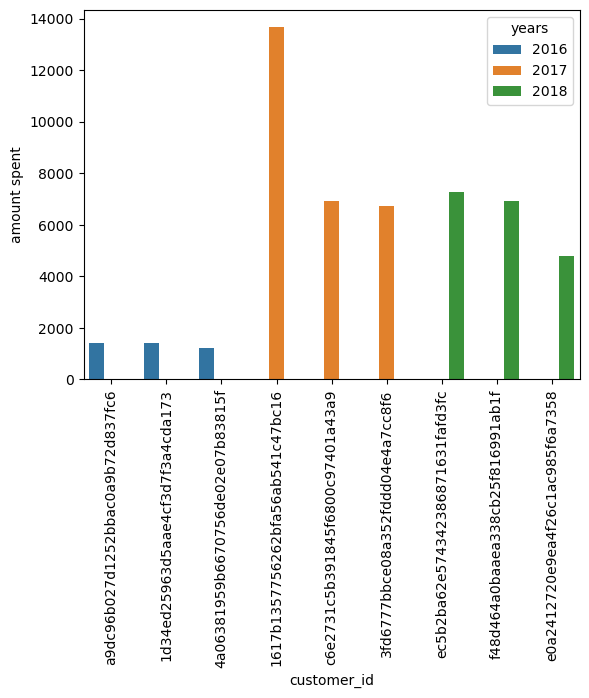

In [40]:
query = """select years, customer_id, payment, d_rank
from 
(select year(orders.order_purchase_timestamp) years,
orders.customer_id, 
sum(payments.payment_value) payment,
dense_rank() over( partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp), orders.customer_id) as a
where d_rank<=3;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "customer_id","amount spent","rank"])
sns.barplot(x = "customer_id", y = "amount spent", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()